In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import ollama
from skollama.models.ollama.classification.zero_shot import ZeroShotOllamaClassifier
from skollama.models.ollama.classification.few_shot import FewShotOllamaClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [29]:
df = pd.read_csv("flipkart\\flipkart_com-ecommerce_sample_1050.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [30]:
df["main_category"] = df['product_category_tree'].str.split(" >> ").str[0].str.replace('["', '')
df['main_category'].value_counts()

main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [31]:
df['name_description'] = df['product_name'] + ' ' + df['description']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df['name_description'], df['main_category'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['main_category'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=42,
                                                  stratify=y_train)

In [33]:
model = ZeroShotOllamaClassifier(model='mistral')

In [34]:
model.fit(None, df['main_category'].unique())

ZeroShotOllamaClassifier(model='mistral')

In [35]:
y_pred = model.predict(X_test)

100%|██████████| 210/210 [10:09<00:00,  2.90s/it]


In [36]:
classification_report(y_test, y_pred)

'                            precision    recall  f1-score   support\n\n                 Baby Care       0.89      0.57      0.69        30\n  Beauty and Personal Care       0.95      0.63      0.76        30\n                 Computers       0.97      0.97      0.97        30\nHome Decor & Festive Needs       0.56      0.80      0.66        30\n           Home Furnishing       0.40      0.70      0.51        30\n          Kitchen & Dining       0.81      0.43      0.57        30\n                   Watches       1.00      1.00      1.00        30\n\n                  accuracy                           0.73       210\n                 macro avg       0.80      0.73      0.74       210\n              weighted avg       0.80      0.73      0.74       210\n'

In [37]:
results = X_test.copy()
results = results.to_frame()
results['true_label'] = y_test
results['zeroshot_pred'] = y_pred

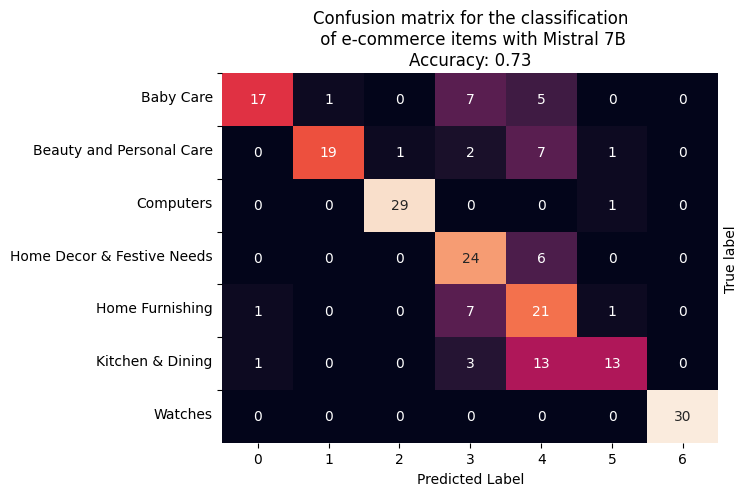

In [38]:
conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

title = f"Confusion matrix for the classification\n of e-commerce items with Mistral 7B\nAccuracy: {accuracy:.2f}"

labels = sorted(df['main_category'].unique())
offset_labels = ["\n\n\n"+l for l in labels]


sns.heatmap(conf_mat, annot=True, cbar=None)
plt.xlabel("Predicted Label")
plt.yticks(labels=offset_labels, ticks=range(0,7), rotation=0)
plt.ylabel("True label")
plt.gca().yaxis.set_label_position("right")
plt.title(title);

In [39]:
round(accuracy_score(y_test,y_pred),3)

0.729

# 2.1 Few-Shot Learning (Small Dataset)

In [40]:

X_train, X_test, y_train, y_test = train_test_split(df['name_description'], df['main_category'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['main_category'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=42,
                                                  stratify=y_train)

In [41]:
few_shot_model = FewShotOllamaClassifier(model='mistral')

few_shot_model.fit(X_train[:49], y_train[:49])

FewShotOllamaClassifier(model='mistral')

In [42]:
y_pred = model.predict(X_test)

100%|██████████| 210/210 [10:08<00:00,  2.90s/it]


In [43]:
results['fewshot_pred'] = y_pred

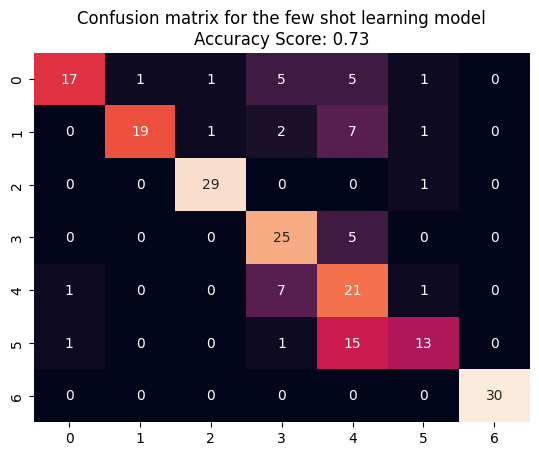

In [44]:
conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


sns.heatmap(conf_mat, annot=True, cbar=None)
plt.title(f"Confusion matrix for the few shot learning model\nAccuracy Score: {accuracy:.2f}");

# 2.2 Few-Shot Learning (Large Dataset)

In [45]:
few_shot_model = FewShotOllamaClassifier(model='mistral')

few_shot_model.fit(X_train, y_train)

FewShotOllamaClassifier(model='mistral')

In [46]:
y_pred = model.predict(X_test)

100%|██████████| 210/210 [10:07<00:00,  2.89s/it]


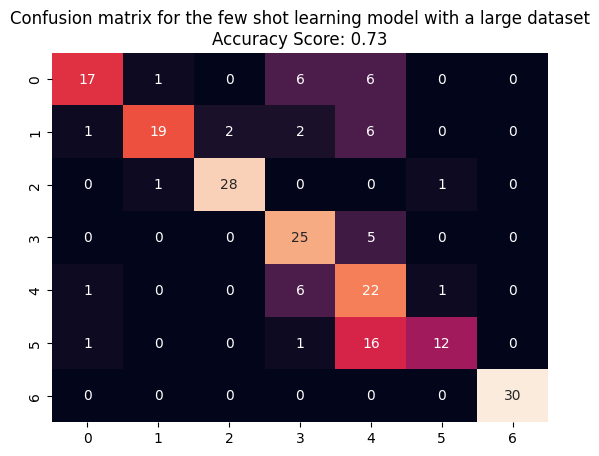

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


sns.heatmap(conf_mat, annot=True, cbar=None)
plt.title(f"Confusion matrix for the few shot learning model with a large dataset\nAccuracy Score: {accuracy:.2f}");

In [48]:
results.head()

,name_description,true_label,zeroshot_pred,fewshot_pred
647,Chokree Baby Girl's A-line Dress Key Features ...,Baby Care,Baby Care,Baby Care
342,Envy-1000 Force Combo Set Flipkart.com: Buy En...,Beauty and Personal Care,Kitchen & Dining,Home Furnishing
895,Just Linen Cotton Bath Towel Just Linen Cotton...,Home Furnishing,Home Furnishing,Home Furnishing
56,Borse N16 Make Up And Jewellery Vanity Case Bu...,Beauty and Personal Care,Beauty and Personal Care,Beauty and Personal Care
386,French Factor Man of the Year Deodorant Gift S...,Beauty and Personal Care,Beauty and Personal Care,Beauty and Personal Care


In [49]:
results.to_csv("output_df.csv", index=False)